[Epoch 1] TrainLoss=5.0269, ValLoss=4.2768
[Epoch 2] TrainLoss=4.3390, ValLoss=4.1537
[Epoch 3] TrainLoss=4.2342, ValLoss=4.1073
[Epoch 4] TrainLoss=4.1844, ValLoss=4.0898
[Epoch 5] TrainLoss=4.1567, ValLoss=4.0718
[Epoch 6] TrainLoss=4.1341, ValLoss=4.0587
[Epoch 7] TrainLoss=4.1182, ValLoss=4.0465
[Epoch 8] TrainLoss=4.1035, ValLoss=4.0428
[Epoch 9] TrainLoss=4.0961, ValLoss=4.0397
[Epoch 10] TrainLoss=4.0884, ValLoss=4.0337
[Epoch 11] TrainLoss=4.0799, ValLoss=4.0225
[Epoch 12] TrainLoss=4.0728, ValLoss=4.0254
[Epoch 13] TrainLoss=4.0702, ValLoss=4.0205
[Epoch 14] TrainLoss=4.0643, ValLoss=4.0182
[Epoch 15] TrainLoss=4.0624, ValLoss=4.0191
[Epoch 16] TrainLoss=4.0573, ValLoss=4.0185
[Epoch 17] TrainLoss=4.0526, ValLoss=4.0145
[Epoch 18] TrainLoss=4.0502, ValLoss=4.0107
[Epoch 19] TrainLoss=4.0471, ValLoss=4.0118
[Epoch 20] TrainLoss=4.0438, ValLoss=4.0157
SupCon training completed.


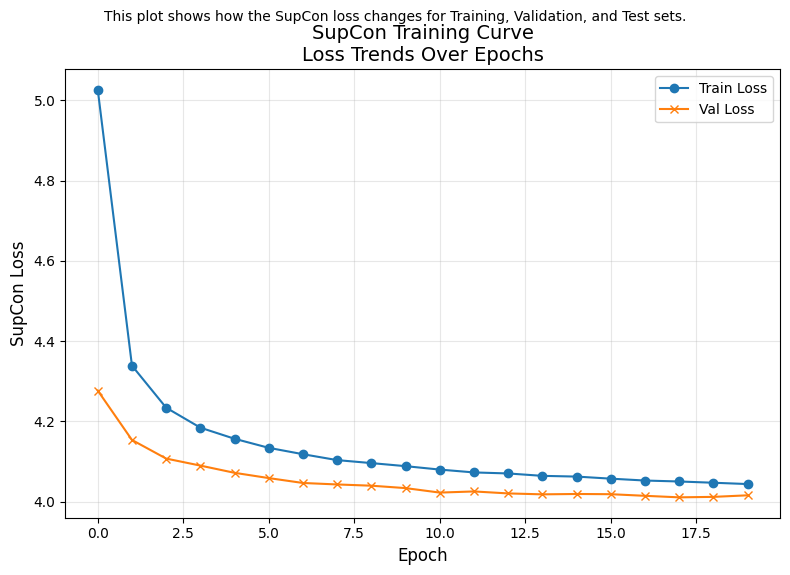

=== Final SupCon Metrics ===
Train Loss: 4.0438
Val   Loss: 4.0157


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sys
sys.path.append('..')
from models.common_autoencoder_blocks import Encoder  
from models.mnist_supconv import MNISTSupCon
from trainers.supcon_trainer import SupConTrainer
from trainers.classifier_trainer import ClassifierTrainer
from models.mnist_classifier import MNISTClassifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class TwoCropsTransform:
    """
    Given one PIL image, apply base_transform twice
    to create two 'views' of the same image.
    """
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        im1 = self.base_transform(x)
        im2 = self.base_transform(x)
        return im1, im2

base_transform = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.ToTensor(),
])

train_transform = TwoCropsTransform(base_transform)
val_base_transform = transforms.Compose([transforms.ToTensor()])
val_transform = TwoCropsTransform(val_base_transform)

data_path = "/datasets/cv_datasets/data"
train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=train_transform)
val_dataset   = datasets.MNIST(root=data_path, train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2, drop_last=True)
supcon = MNISTSupCon(
    input_shape=(1,28,28),
    channels=[32,64],
    kernel_sizes=[3,3],
    strides=[2,2],
    paddings=[1,1],
    latent_dim=128,
    hidden_dims=[1024],
    batch_norm_conv=True
)
optimizer = torch.optim.Adam(supcon.parameters(), lr=1e-4, weight_decay=1e-4)

supcon_trainer = SupConTrainer(
    model=supcon,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=20,
    patience=3,
    temperature=0.07
)
supcon_trainer.train()
supcon_trainer.plot_metrics()

Epoch [1] - TrainAcc: 0.9425, ValAcc: 0.9925 | ValLoss: 0.1530
Epoch [2] - TrainAcc: 0.9889, ValAcc: 0.9928 | ValLoss: 0.0678
Epoch [3] - TrainAcc: 0.9893, ValAcc: 0.9927 | ValLoss: 0.0455
Epoch [4] - TrainAcc: 0.9895, ValAcc: 0.9933 | ValLoss: 0.0344
Epoch [5] - TrainAcc: 0.9892, ValAcc: 0.9933 | ValLoss: 0.0308
Epoch [6] - TrainAcc: 0.9897, ValAcc: 0.9931 | ValLoss: 0.0279
Epoch [7] - TrainAcc: 0.9899, ValAcc: 0.9932 | ValLoss: 0.0255
Epoch [8] - TrainAcc: 0.9900, ValAcc: 0.9929 | ValLoss: 0.0256
Epoch [9] - TrainAcc: 0.9900, ValAcc: 0.9928 | ValLoss: 0.0252
Epoch [10] - TrainAcc: 0.9900, ValAcc: 0.9935 | ValLoss: 0.0237
Epoch [11] - TrainAcc: 0.9900, ValAcc: 0.9936 | ValLoss: 0.0236
Epoch [12] - TrainAcc: 0.9903, ValAcc: 0.9932 | ValLoss: 0.0225
Epoch [13] - TrainAcc: 0.9905, ValAcc: 0.9929 | ValLoss: 0.0230
Epoch [14] - TrainAcc: 0.9901, ValAcc: 0.9930 | ValLoss: 0.0229
Epoch [15] - TrainAcc: 0.9902, ValAcc: 0.9932 | ValLoss: 0.0231
Early stopping triggered at epoch 15
Final val ac

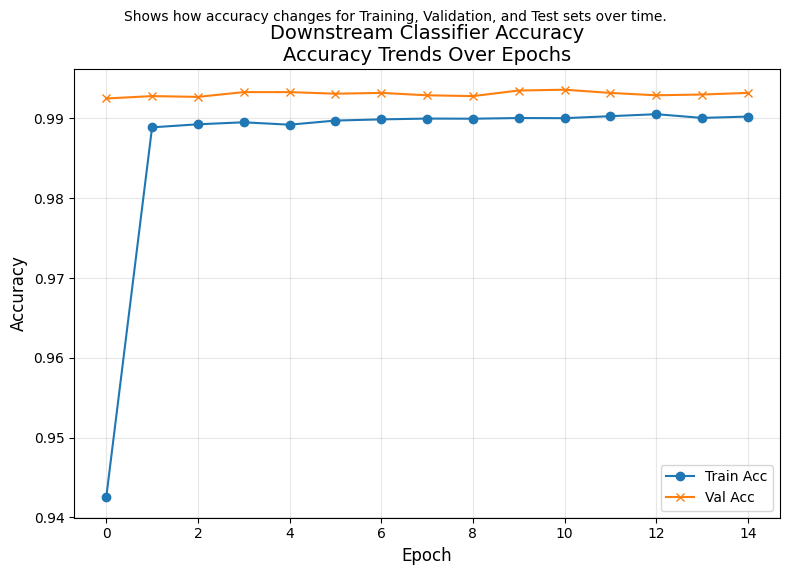

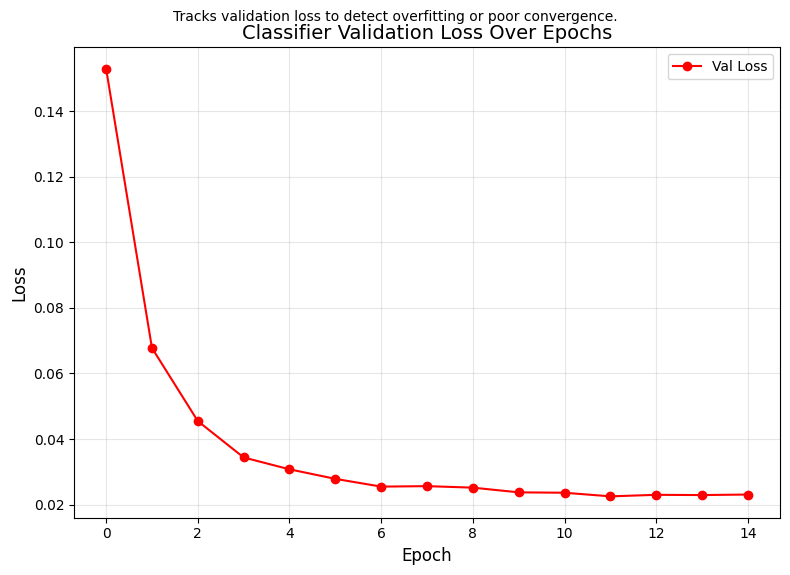

=== Final Classifier Metrics ===
Val Loss: 0.0231
Train Acc: 99.02%
Val   Acc: 99.32%


In [2]:
classification_train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])
classification_val_transform = transforms.ToTensor()

train_dataset_calssification = datasets.MNIST(root=data_path, train=True, download=False, transform=classification_train_transform)
val_dataset_calssification   = datasets.MNIST(root=data_path, train=False, download=False, transform=classification_val_transform)
train_calssification_loader = DataLoader(train_dataset_calssification, batch_size=64, shuffle=True)
val_calssification_loader = DataLoader(val_dataset_calssification, batch_size=64, shuffle=False)
classifier = MNISTClassifier(latent_dim=128, num_classes=10, batch_norm_fc=True) 
classifier_trainer = ClassifierTrainer(
    encoder=supcon,
    classifier=classifier,
    train_loader=train_calssification_loader,
    val_loader=val_calssification_loader,
    device=device,
    lr=1e-4,
    weight_decay=1e-4,
    num_epochs=20,
    patience=3,
)
classifier_trainer.train()
classifier_trainer.plot_metrics()

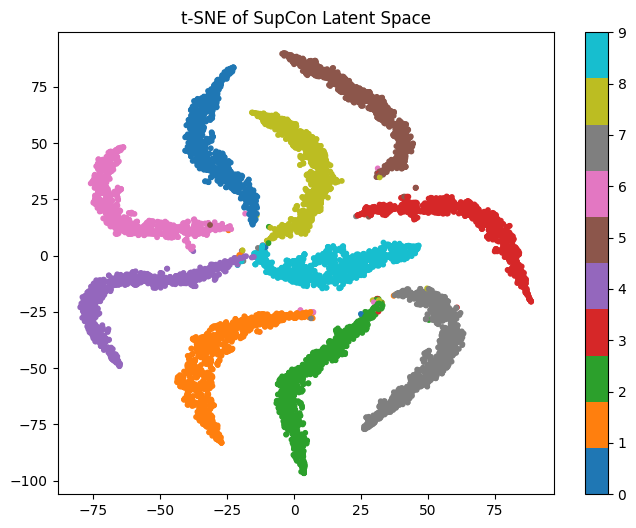

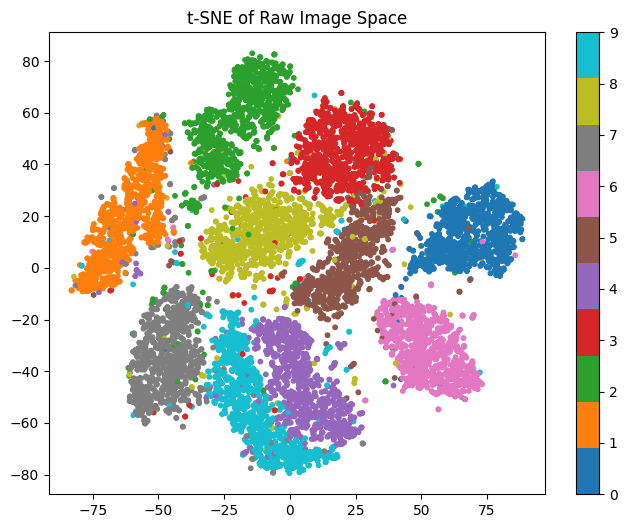

In [7]:
from utils import plot_tsne_supcon
plot_tsne_supcon(supcon, val_calssification_loader, device='cuda')
